In [1]:
import os
from sklearn.model_selection import train_test_split
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import sys
sys.path.insert(0, r'C:\Users\USER\Desktop\CNN_GAP')
from utils.preprocess import pad_sequences
from utils.F1 import F1
from net.FS import FS
from net.FE import FE
from net.net2 import CNN_GAP2
from dataset.mydataset import myDataset
from scipy.signal import resample

In [2]:
Xtrain = None
with open('../Xtrain', 'rb') as fp:
    Xtrain = pickle.load(fp)

Ytrain = np.load('../Ytrain.npy')

print('# of Xtrain:', len(Xtrain))
print('Shape of Ytrain', Ytrain.shape)


# of Xtrain: 8528
Shape of Ytrain (8528,)


In [3]:
idx = np.where(Ytrain == 3)
Xtrain_won = np.delete(Xtrain, idx, axis=0)
Ytrain_won = np.delete(Ytrain, idx, axis=0)
print(Xtrain_won.shape)
print(Ytrain_won.shape)

(8244,)
(8244,)


In [4]:
Xtrain_new = []
Ytrain_new = []
cut_len = 9000
thres = 0.65
for i in range(len(Xtrain_won)):
    cut = len(Xtrain_won[i]) // cut_len
    for j in range(1, cut+1):
        Xtrain_new.append(Xtrain_won[i][(j-1)*cut_len:j*cut_len])
        Ytrain_new.append(Ytrain_won[i])        
    if len(Xtrain_won[i]) % cut_len >= int(cut_len*thres):
        x_remain = Xtrain_won[i][cut*cut_len:]
        remainder = cut_len - len(x_remain)
        Xtrain_new.append(np.pad(x_remain, (int(remainder/2), remainder - int(remainder/2)), 'constant', constant_values=0))
        Ytrain_new.append(Ytrain_won[i])

In [5]:
train_data = np.array(Xtrain_new).reshape(len(Ytrain_new),1,cut_len)
train_label = np.array(Ytrain_new)
print(train_data.shape, train_label.shape)

(8738, 1, 9000) (8738,)


In [6]:
train_data, valid_data, train_label, valid_label = train_test_split(train_data, train_label, test_size=0.3, random_state=42)
train_data = torch.from_numpy(train_data).float()
valid_data = torch.from_numpy(valid_data).float()
train_label = torch.from_numpy(train_label).long()
valid_label = torch.from_numpy(valid_label).long()
print(train_data.shape, train_label.shape, valid_data.shape, valid_label.shape)

torch.Size([6116, 1, 9000]) torch.Size([6116]) torch.Size([2622, 1, 9000]) torch.Size([2622])


In [7]:
try:
    os.mkdir('confusion matrix')
except:
    pass

In [8]:
filename = 'model3/'
file_list = os.listdir(filename)
file_list.sort()
end_name = file_list[-2].split('_')[2]

In [9]:
enc = FE(int(cut_len/8))
sel = FS()
print("Load from: ",filename+'model_enc_'+end_name)
print("Load from: ",filename+'model_sel_'+end_name)
enc.load_state_dict(torch.load(filename+'model_enc_'+end_name))
sel.load_state_dict(torch.load(filename+'model_sel_'+end_name))
enc = enc.cuda()
sel = sel.cuda()
enc.eval()
sel.eval()

Load from:  model3/model_enc_00080-0.92528-0.92631-0.85965-0.83339.h5
Load from:  model3/model_sel_00080-0.92528-0.92631-0.85965-0.83339.h5


FS(
  (outlayer): Linear(in_features=64, out_features=3, bias=True)
)

In [10]:
batch_size = 2
validloader = DataLoader(myDataset(valid_data, valid_label, is_train=False), batch_size=batch_size)  # no aug. for valid data

pred_label = []

for i, data in enumerate(validloader, 0):
    if i % 5 == 0:
        print('Calculate %4d'% i, end = '\r')
    inputs, labels = data
    inputs = inputs.cuda()
    labels = labels.cuda()

    # forward + backward + optimize
    outputs = sel(enc(inputs))
    predict_labels = torch.argmax(outputs, dim=1).cpu().numpy()
    pred_label.append(predict_labels)

Confusion matrix, without normalization
[[1428    6  150]
 [  12  182   31]
 [ 132   37  644]]
Normalized confusion matrix
[[0.9  0.   0.09]
 [0.05 0.81 0.14]
 [0.16 0.05 0.79]]


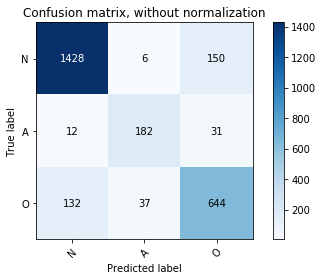

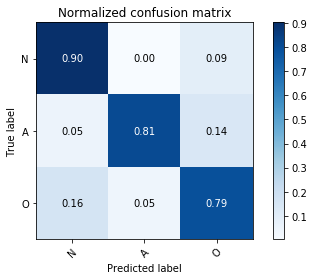

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)
y_test = valid_label.numpy()
y_pred = np.array(pred_label).reshape(-1)
class_names = np.array(['N','A','O'])
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig('confusion matrix/'+filename[:-1]+'_unnorm.jpg')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('confusion matrix/'+filename[:-1]+'_norm.jpg')